In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import zipfile
from io import BytesIO
from haversine import haversine, Unit
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.feature_extraction import DictVectorizer

In [4]:
with zipfile.ZipFile("./data/202205-capitalbikeshare-tripdata.zip", "r") as f:
    for name in f.namelist():
        if name.endswith('.csv'):
            with f.open(name) as zd:
                df = pd.read_csv(zd)
            break

In [5]:
df.head()

ride_id  rideable_type           started_at             ended_at  \
0  933DB56B508F5DCD   classic_bike  2022-05-12 18:19:28  2022-05-12 18:26:41   
1  48B50E20E9B24CA7   classic_bike  2022-05-27 16:24:42  2022-05-27 16:51:51   
2  96444E8B2485BA6D   classic_bike  2022-05-29 19:16:55  2022-05-29 19:22:31   
3  37FE6E9EB6768E2A  electric_bike  2022-05-11 12:30:58  2022-05-11 12:35:36   
4  8FD653C76B951755   classic_bike  2022-05-03 19:16:22  2022-05-03 19:50:30   

               start_station_name  start_station_id  \
0             15th & Euclid St NW           31117.0   
1  17th St & Massachusetts Ave NW           31267.0   
2             15th & Euclid St NW           31117.0   
3  17th St & Massachusetts Ave NW           31267.0   
4        Windham Ln & Amherst Ave           32066.0   

              end_station_name  end_station_id  start_lat  start_lng  \
0      Park Rd & Holmead Pl NW         31602.0  38.923330 -77.035200   
1           3rd & Tingey St SE         31634.0  38.908142 -77.038359   
2  Columbia Rd & Belmont St NW         31113.0  38.923330 -77.035200   
3               15th & W St NW         31125.0  38.908131 -77.038435   
4     Windham Ln & Amherst Ave         32066.0  39.032029 -77.047350   

     end_lat    end_lng member_casual  
0  38.930800 -77.031500        member  
1  38.875010 -77.002400        member  
2  38.920669 -77.043680        member  
3  38.919018 -77.034449        member  
4  39.032029 -77.047350        casual

In [6]:
df.shape

(332821, 13)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332821 entries, 0 to 332820
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ride_id             332821 non-null  object 
 1   rideable_type       332821 non-null  object 
 2   started_at          332821 non-null  object 
 3   ended_at            332821 non-null  object 
 4   start_station_name  319064 non-null  object 
 5   start_station_id    319064 non-null  float64
 6   end_station_name    317296 non-null  object 
 7   end_station_id      317296 non-null  float64
 8   start_lat           332821 non-null  float64
 9   start_lng           332821 non-null  float64
 10  end_lat             332267 non-null  float64
 11  end_lng             332267 non-null  float64
 12  member_casual       332821 non-null  object 
dtypes: float64(6), object(7)
memory usage: 33.0+ MB


In [8]:
df.started_at = pd.to_datetime(df.started_at)
df.ended_at = pd.to_datetime(df.ended_at)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332821 entries, 0 to 332820
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   ride_id             332821 non-null  object        
 1   rideable_type       332821 non-null  object        
 2   started_at          332821 non-null  datetime64[ns]
 3   ended_at            332821 non-null  datetime64[ns]
 4   start_station_name  319064 non-null  object        
 5   start_station_id    319064 non-null  float64       
 6   end_station_name    317296 non-null  object        
 7   end_station_id      317296 non-null  float64       
 8   start_lat           332821 non-null  float64       
 9   start_lng           332821 non-null  float64       
 10  end_lat             332267 non-null  float64       
 11  end_lng             332267 non-null  float64       
 12  member_casual       332821 non-null  object        
dtypes: datetime64[ns](2), float64

In [9]:
df.head()

ride_id  rideable_type          started_at            ended_at  \
0  933DB56B508F5DCD   classic_bike 2022-05-12 18:19:28 2022-05-12 18:26:41   
1  48B50E20E9B24CA7   classic_bike 2022-05-27 16:24:42 2022-05-27 16:51:51   
2  96444E8B2485BA6D   classic_bike 2022-05-29 19:16:55 2022-05-29 19:22:31   
3  37FE6E9EB6768E2A  electric_bike 2022-05-11 12:30:58 2022-05-11 12:35:36   
4  8FD653C76B951755   classic_bike 2022-05-03 19:16:22 2022-05-03 19:50:30   

               start_station_name  start_station_id  \
0             15th & Euclid St NW           31117.0   
1  17th St & Massachusetts Ave NW           31267.0   
2             15th & Euclid St NW           31117.0   
3  17th St & Massachusetts Ave NW           31267.0   
4        Windham Ln & Amherst Ave           32066.0   

              end_station_name  end_station_id  start_lat  start_lng  \
0      Park Rd & Holmead Pl NW         31602.0  38.923330 -77.035200   
1           3rd & Tingey St SE         31634.0  38.908142 -77.038359   
2  Columbia Rd & Belmont St NW         31113.0  38.923330 -77.035200   
3               15th & W St NW         31125.0  38.908131 -77.038435   
4     Windham Ln & Amherst Ave         32066.0  39.032029 -77.047350   

     end_lat    end_lng member_casual  
0  38.930800 -77.031500        member  
1  38.875010 -77.002400        member  
2  38.920669 -77.043680        member  
3  38.919018 -77.034449        member  
4  39.032029 -77.047350        casual

In [10]:
df["duration"] = df.ended_at - df.started_at
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df.head()

ride_id  rideable_type          started_at            ended_at  \
0  933DB56B508F5DCD   classic_bike 2022-05-12 18:19:28 2022-05-12 18:26:41   
1  48B50E20E9B24CA7   classic_bike 2022-05-27 16:24:42 2022-05-27 16:51:51   
2  96444E8B2485BA6D   classic_bike 2022-05-29 19:16:55 2022-05-29 19:22:31   
3  37FE6E9EB6768E2A  electric_bike 2022-05-11 12:30:58 2022-05-11 12:35:36   
4  8FD653C76B951755   classic_bike 2022-05-03 19:16:22 2022-05-03 19:50:30   

               start_station_name  start_station_id  \
0             15th & Euclid St NW           31117.0   
1  17th St & Massachusetts Ave NW           31267.0   
2             15th & Euclid St NW           31117.0   
3  17th St & Massachusetts Ave NW           31267.0   
4        Windham Ln & Amherst Ave           32066.0   

              end_station_name  end_station_id  start_lat  start_lng  \
0      Park Rd & Holmead Pl NW         31602.0  38.923330 -77.035200   
1           3rd & Tingey St SE         31634.0  38.908142 -77.038359   
2  Columbia Rd & Belmont St NW         31113.0  38.923330 -77.035200   
3               15th & W St NW         31125.0  38.908131 -77.038435   
4     Windham Ln & Amherst Ave         32066.0  39.032029 -77.047350   

     end_lat    end_lng member_casual   duration  
0  38.930800 -77.031500        member   7.216667  
1  38.875010 -77.002400        member  27.150000  
2  38.920669 -77.043680        member   5.600000  
3  38.919018 -77.034449        member   4.633333  
4  39.032029 -77.047350        casual  34.133333

In [11]:
((df.duration >= 1) & (df.duration <= 60)).sum()

310389

In [12]:
df.to_parquet("./data/202205-capitalbikeshare-tripdata.parquet", engine="pyarrow")

In [13]:
df = pd.read_parquet("./data/202205-capitalbikeshare-tripdata.parquet", engine="pyarrow")
df.head()

ride_id  rideable_type          started_at            ended_at  \
0  933DB56B508F5DCD   classic_bike 2022-05-12 18:19:28 2022-05-12 18:26:41   
1  48B50E20E9B24CA7   classic_bike 2022-05-27 16:24:42 2022-05-27 16:51:51   
2  96444E8B2485BA6D   classic_bike 2022-05-29 19:16:55 2022-05-29 19:22:31   
3  37FE6E9EB6768E2A  electric_bike 2022-05-11 12:30:58 2022-05-11 12:35:36   
4  8FD653C76B951755   classic_bike 2022-05-03 19:16:22 2022-05-03 19:50:30   

               start_station_name  start_station_id  \
0             15th & Euclid St NW           31117.0   
1  17th St & Massachusetts Ave NW           31267.0   
2             15th & Euclid St NW           31117.0   
3  17th St & Massachusetts Ave NW           31267.0   
4        Windham Ln & Amherst Ave           32066.0   

              end_station_name  end_station_id  start_lat  start_lng  \
0      Park Rd & Holmead Pl NW         31602.0  38.923330 -77.035200   
1           3rd & Tingey St SE         31634.0  38.908142 -77.038359   
2  Columbia Rd & Belmont St NW         31113.0  38.923330 -77.035200   
3               15th & W St NW         31125.0  38.908131 -77.038435   
4     Windham Ln & Amherst Ave         32066.0  39.032029 -77.047350   

     end_lat    end_lng member_casual   duration  
0  38.930800 -77.031500        member   7.216667  
1  38.875010 -77.002400        member  27.150000  
2  38.920669 -77.043680        member   5.600000  
3  38.919018 -77.034449        member   4.633333  
4  39.032029 -77.047350        casual  34.133333

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332821 entries, 0 to 332820
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   ride_id             332821 non-null  object        
 1   rideable_type       332821 non-null  object        
 2   started_at          332821 non-null  datetime64[ns]
 3   ended_at            332821 non-null  datetime64[ns]
 4   start_station_name  319064 non-null  object        
 5   start_station_id    319064 non-null  float64       
 6   end_station_name    317296 non-null  object        
 7   end_station_id      317296 non-null  float64       
 8   start_lat           332821 non-null  float64       
 9   start_lng           332821 non-null  float64       
 10  end_lat             332267 non-null  float64       
 11  end_lng             332267 non-null  float64       
 12  member_casual       332821 non-null  object        
 13  duration            332821 no

In [17]:
df["rideable_type"].nunique()

3

In [18]:
df["rideable_type"].unique()

array(['classic_bike', 'electric_bike', 'docked_bike'], dtype=object)

In [19]:
df["rideable_type"].value_counts()

classic_bike     254129
electric_bike     52933
docked_bike       25759
Name: rideable_type, dtype: int64

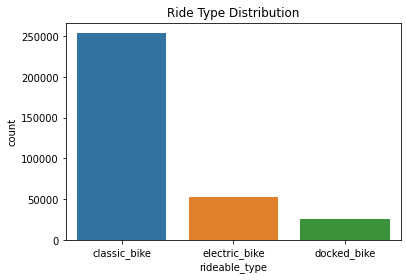

In [20]:
sns.countplot(x="rideable_type", data=df)
plt.title("Ride Type Distribution");

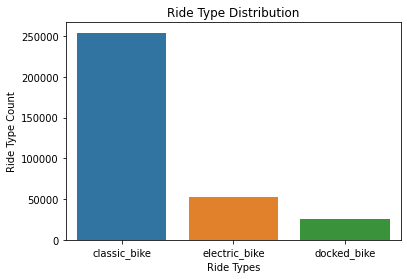

In [21]:
ride_types = df["rideable_type"].value_counts()
sns.barplot(x=ride_types.index, y=ride_types)
plt.title("Ride Type Distribution")
plt.xlabel("Ride Types")
plt.ylabel("Ride Type Count");

In [22]:
df["member_casual"].nunique()

2

In [23]:
df["member_casual"].unique()

array(['member', 'casual'], dtype=object)

In [24]:
df["member_casual"].value_counts()

member    185200
casual    147621
Name: member_casual, dtype: int64

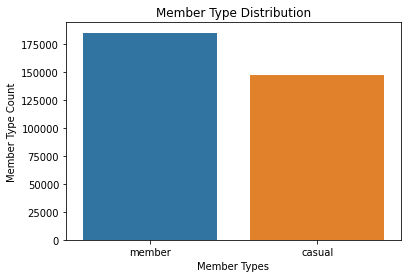

In [25]:
member_types = df["member_casual"].value_counts()
sns.barplot(x=member_types.index, y=member_types)
plt.title("Member Type Distribution")
plt.xlabel("Member Types")
plt.ylabel("Member Type Count");

In [26]:
df["start_station_name"].nunique()

687

In [27]:
df["start_station_name"].unique()[:20]

array(['15th & Euclid St NW', '17th St & Massachusetts Ave NW',
       'Windham Ln & Amherst Ave', 'King Farm Blvd & Pleasant Dr',
       'Clarendon Blvd & Pierce St', 'C & O Canal & Wisconsin Ave NW',
       '19th & East Capitol St SE',
       'Penrose Sq/Columbia Pike & S Barton St', '18th & L St NW',
       'Fairfax Dr & N Randolph St', 'Georgetown Harbor / 30th St NW',
       'Eckington Pl & Q St NE', 'Eads St & 22nd St S',
       '13th St & New York Ave NW',
       'Central Library / Quincy St & 10th St N', '21st & I St NW',
       '3rd & Tingey St SE', '3rd & M St NE',
       'Montgomery Ave & Waverly St ', '4th & D St NW / Judiciary Square'],
      dtype=object)

In [28]:
df["start_station_name"].value_counts().sort_values(ascending=False).head(10)

Lincoln Memorial                                         4008
Jefferson Dr & 14th St SW                                3526
Smithsonian-National Mall / Jefferson Dr & 12th St SW    3302
Columbus Circle / Union Station                          3296
New Hampshire Ave & T St NW                              3136
15th & P St NW                                           3100
4th St & Madison Dr NW                                   3084
Henry Bacon Dr & Lincoln Memorial Circle NW              2921
1st & M St NE                                            2752
Eastern Market Metro / Pennsylvania Ave & 8th St SE      2426
Name: start_station_name, dtype: int64

In [29]:
df["end_station_name"].value_counts().sort_values(ascending=False).head(10)

Lincoln Memorial                                         3973
Jefferson Dr & 14th St SW                                3553
Columbus Circle / Union Station                          3451
Smithsonian-National Mall / Jefferson Dr & 12th St SW    3266
New Hampshire Ave & T St NW                              3153
15th & P St NW                                           3131
4th St & Madison Dr NW                                   3033
Henry Bacon Dr & Lincoln Memorial Circle NW              2955
1st & M St NE                                            2807
Massachusetts Ave & Dupont Circle NW                     2697
Name: end_station_name, dtype: int64

In [30]:
missing_values_sum = df.isna().sum()
missing_values_sum

ride_id                   0
rideable_type             0
started_at                0
ended_at                  0
start_station_name    13757
start_station_id      13757
end_station_name      15525
end_station_id        15525
start_lat                 0
start_lng                 0
end_lat                 554
end_lng                 554
member_casual             0
duration                  0
dtype: int64

In [31]:
missing_values_pct = (df.isna().sum() / len(df)) * 100
missing_values_pct

ride_id               0.000000
rideable_type         0.000000
started_at            0.000000
ended_at              0.000000
start_station_name    4.133453
start_station_id      4.133453
end_station_name      4.664670
end_station_id        4.664670
start_lat             0.000000
start_lng             0.000000
end_lat               0.166456
end_lng               0.166456
member_casual         0.000000
duration              0.000000
dtype: float64

In [32]:
df.dropna(inplace=True)
df.head()

ride_id  rideable_type          started_at            ended_at  \
0  933DB56B508F5DCD   classic_bike 2022-05-12 18:19:28 2022-05-12 18:26:41   
1  48B50E20E9B24CA7   classic_bike 2022-05-27 16:24:42 2022-05-27 16:51:51   
2  96444E8B2485BA6D   classic_bike 2022-05-29 19:16:55 2022-05-29 19:22:31   
3  37FE6E9EB6768E2A  electric_bike 2022-05-11 12:30:58 2022-05-11 12:35:36   
4  8FD653C76B951755   classic_bike 2022-05-03 19:16:22 2022-05-03 19:50:30   

               start_station_name  start_station_id  \
0             15th & Euclid St NW           31117.0   
1  17th St & Massachusetts Ave NW           31267.0   
2             15th & Euclid St NW           31117.0   
3  17th St & Massachusetts Ave NW           31267.0   
4        Windham Ln & Amherst Ave           32066.0   

              end_station_name  end_station_id  start_lat  start_lng  \
0      Park Rd & Holmead Pl NW         31602.0  38.923330 -77.035200   
1           3rd & Tingey St SE         31634.0  38.908142 -77.038359   
2  Columbia Rd & Belmont St NW         31113.0  38.923330 -77.035200   
3               15th & W St NW         31125.0  38.908131 -77.038435   
4     Windham Ln & Amherst Ave         32066.0  39.032029 -77.047350   

     end_lat    end_lng member_casual   duration  
0  38.930800 -77.031500        member   7.216667  
1  38.875010 -77.002400        member  27.150000  
2  38.920669 -77.043680        member   5.600000  
3  38.919018 -77.034449        member   4.633333  
4  39.032029 -77.047350        casual  34.133333

In [33]:
df.shape

(310801, 14)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 310801 entries, 0 to 332820
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   ride_id             310801 non-null  object        
 1   rideable_type       310801 non-null  object        
 2   started_at          310801 non-null  datetime64[ns]
 3   ended_at            310801 non-null  datetime64[ns]
 4   start_station_name  310801 non-null  object        
 5   start_station_id    310801 non-null  float64       
 6   end_station_name    310801 non-null  object        
 7   end_station_id      310801 non-null  float64       
 8   start_lat           310801 non-null  float64       
 9   start_lng           310801 non-null  float64       
 10  end_lat             310801 non-null  float64       
 11  end_lng             310801 non-null  float64       
 12  member_casual       310801 non-null  object        
 13  duration            310801 no

In [35]:
df["start_end_station_combination"] = df["start_station_name"] + " - " + df["end_station_name"]
df.head()

ride_id  rideable_type          started_at            ended_at  \
0  933DB56B508F5DCD   classic_bike 2022-05-12 18:19:28 2022-05-12 18:26:41   
1  48B50E20E9B24CA7   classic_bike 2022-05-27 16:24:42 2022-05-27 16:51:51   
2  96444E8B2485BA6D   classic_bike 2022-05-29 19:16:55 2022-05-29 19:22:31   
3  37FE6E9EB6768E2A  electric_bike 2022-05-11 12:30:58 2022-05-11 12:35:36   
4  8FD653C76B951755   classic_bike 2022-05-03 19:16:22 2022-05-03 19:50:30   

               start_station_name  start_station_id  \
0             15th & Euclid St NW           31117.0   
1  17th St & Massachusetts Ave NW           31267.0   
2             15th & Euclid St NW           31117.0   
3  17th St & Massachusetts Ave NW           31267.0   
4        Windham Ln & Amherst Ave           32066.0   

              end_station_name  end_station_id  start_lat  start_lng  \
0      Park Rd & Holmead Pl NW         31602.0  38.923330 -77.035200   
1           3rd & Tingey St SE         31634.0  38.908142 -77.038359   
2  Columbia Rd & Belmont St NW         31113.0  38.923330 -77.035200   
3               15th & W St NW         31125.0  38.908131 -77.038435   
4     Windham Ln & Amherst Ave         32066.0  39.032029 -77.047350   

     end_lat    end_lng member_casual   duration  \
0  38.930800 -77.031500        member   7.216667   
1  38.875010 -77.002400        member  27.150000   
2  38.920669 -77.043680        member   5.600000   
3  38.919018 -77.034449        member   4.633333   
4  39.032029 -77.047350        casual  34.133333   

                       start_end_station_combination  
0      15th & Euclid St NW - Park Rd & Holmead Pl NW  
1  17th St & Massachusetts Ave NW - 3rd & Tingey ...  
2  15th & Euclid St NW - Columbia Rd & Belmont St NW  
3    17th St & Massachusetts Ave NW - 15th & W St NW  
4  Windham Ln & Amherst Ave - Windham Ln & Amhers...

In [36]:
mean_duration_by_start_end_station = (
    df.groupby("start_end_station_combination")["duration"]
    .mean()
    .sort_values(ascending=False)
)
mean_duration_by_start_end_station.head(10)

start_end_station_combination
4th & Florida Ave NE - 6035 Warehouse                                                                 41387.033333
Washington Blvd & Walter Reed Dr  - George Mason Dr & Wilson Blvd                                     24253.333333
8th & Eye St SE / Barracks Row - 6035 Warehouse                                                        8744.133333
Benning Rd & East Capitol St NE / Benning Rd Metro - Clarendon Metro / Wilson Blvd & N Highland St     5562.066667
Reston Town Center Transit Station - Reston YMCA                                                       5501.908333
National Harbor Carousel - Braddock Rd Metro South                                                     5079.250000
19th St & Constitution Ave NW - US Dept of State / Virginia Ave & 21st St NW                           3834.450000
37th & O St NW / Georgetown University - 6035 Warehouse                                                2133.533333
Tysons Corner Station - Jones Branch & Westbranch 

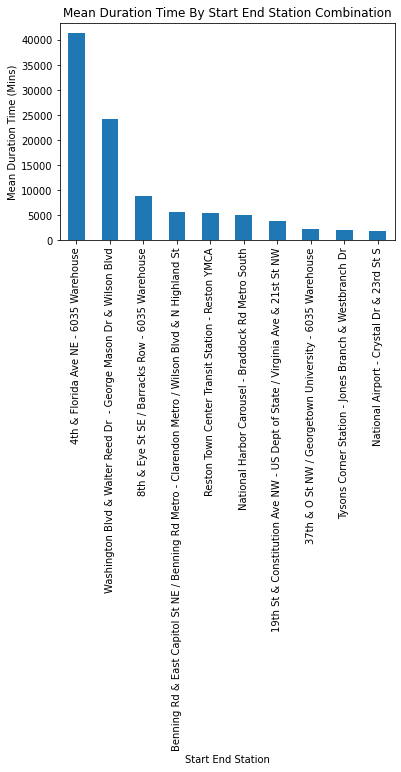

In [37]:
mean_duration_by_start_end_station.head(10).plot(
    kind="bar",
    xlabel="Start End Station",
    ylabel="Mean Duration Time (Mins)",
    title="Mean Duration Time By Start End Station Combination"
);

In [38]:
df.corr()

start_station_id  end_station_id  start_lat  start_lng  \
start_station_id          1.000000        0.485921   0.035452   0.171886   
end_station_id            0.485921        1.000000   0.044197   0.079893   
start_lat                 0.035452        0.044197   1.000000  -0.077845   
start_lng                 0.171886        0.079893  -0.077845   1.000000   
end_lat                   0.056575        0.032274   0.818460  -0.059892   
end_lng                   0.079817        0.177052  -0.064425   0.827099   
duration                  0.005281        0.015025  -0.025452  -0.021167   

                   end_lat   end_lng  duration  
start_station_id  0.056575  0.079817  0.005281  
end_station_id    0.032274  0.177052  0.015025  
start_lat         0.818460 -0.064425 -0.025452  
start_lng        -0.059892  0.827099 -0.021167  
end_lat           1.000000 -0.073288 -0.021575  
end_lng          -0.073288  1.000000 -0.022142  
duration         -0.021575 -0.022142  1.000000

In [39]:
corr = df.drop(columns="duration").corr()
corr

start_station_id  end_station_id  start_lat  start_lng  \
start_station_id          1.000000        0.485921   0.035452   0.171886   
end_station_id            0.485921        1.000000   0.044197   0.079893   
start_lat                 0.035452        0.044197   1.000000  -0.077845   
start_lng                 0.171886        0.079893  -0.077845   1.000000   
end_lat                   0.056575        0.032274   0.818460  -0.059892   
end_lng                   0.079817        0.177052  -0.064425   0.827099   

                   end_lat   end_lng  
start_station_id  0.056575  0.079817  
end_station_id    0.032274  0.177052  
start_lat         0.818460 -0.064425  
start_lng        -0.059892  0.827099  
end_lat           1.000000 -0.073288  
end_lng          -0.073288  1.000000

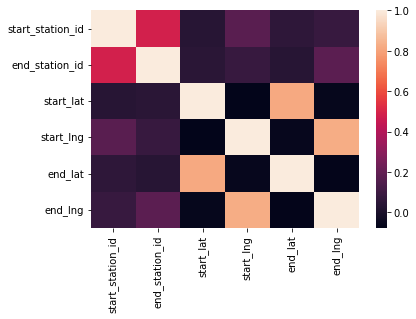

In [40]:
sns.heatmap(corr);

In [41]:
df.head()

ride_id  rideable_type          started_at            ended_at  \
0  933DB56B508F5DCD   classic_bike 2022-05-12 18:19:28 2022-05-12 18:26:41   
1  48B50E20E9B24CA7   classic_bike 2022-05-27 16:24:42 2022-05-27 16:51:51   
2  96444E8B2485BA6D   classic_bike 2022-05-29 19:16:55 2022-05-29 19:22:31   
3  37FE6E9EB6768E2A  electric_bike 2022-05-11 12:30:58 2022-05-11 12:35:36   
4  8FD653C76B951755   classic_bike 2022-05-03 19:16:22 2022-05-03 19:50:30   

               start_station_name  start_station_id  \
0             15th & Euclid St NW           31117.0   
1  17th St & Massachusetts Ave NW           31267.0   
2             15th & Euclid St NW           31117.0   
3  17th St & Massachusetts Ave NW           31267.0   
4        Windham Ln & Amherst Ave           32066.0   

              end_station_name  end_station_id  start_lat  start_lng  \
0      Park Rd & Holmead Pl NW         31602.0  38.923330 -77.035200   
1           3rd & Tingey St SE         31634.0  38.908142 -77.038359   
2  Columbia Rd & Belmont St NW         31113.0  38.923330 -77.035200   
3               15th & W St NW         31125.0  38.908131 -77.038435   
4     Windham Ln & Amherst Ave         32066.0  39.032029 -77.047350   

     end_lat    end_lng member_casual   duration  \
0  38.930800 -77.031500        member   7.216667   
1  38.875010 -77.002400        member  27.150000   
2  38.920669 -77.043680        member   5.600000   
3  38.919018 -77.034449        member   4.633333   
4  39.032029 -77.047350        casual  34.133333   

                       start_end_station_combination  
0      15th & Euclid St NW - Park Rd & Holmead Pl NW  
1  17th St & Massachusetts Ave NW - 3rd & Tingey ...  
2  15th & Euclid St NW - Columbia Rd & Belmont St NW  
3    17th St & Massachusetts Ave NW - 15th & W St NW  
4  Windham Ln & Amherst Ave - Windham Ln & Amhers...

In [2]:
def read_data(filepath):
    """
    Returns cleaned dataframe
    """
    # Read csv zip file into dataframe
    with zipfile.ZipFile(filepath, "r") as f:
        for name in f.namelist():
            if name.endswith('.csv'):
                with f.open(name) as zd:
                    df = pd.read_csv(zd)
                break
    
    
    return df
    

In [3]:
def save_to_parquet(df, filepath):
    """
    Saves dataframe to parquet format
    """
    # Generate destination parquet path
    dest_path = filepath.split(".")
    dest_path = f".{dest_path[1]}.parquet"
    
    # Save file destination path
    df.to_parquet(dest_path, engine="pyarrow", index=False)
    
    return dest_path

In [4]:
def distance(row):
    """
    Returns distance between two geo-location coordinates
    """
    start = (row["start_lat"], row["start_lng"])
    end = (row["end_lat"], row["end_lng"])
    distance = haversine(start, end, unit=Unit.MILES)
    
    return distance

In [38]:
def prepare_data(dest_path):
    """
    Wrangle and return cleaned dataframe
    """
    # Read parquet to dataframe
    df = pd.read_parquet(dest_path)
    
    # Change datetime columns to datatime datatype
    df.started_at = pd.to_datetime(df.started_at)
    df.ended_at = pd.to_datetime(df.ended_at)
    
    df["duration"] = df.ended_at - df.started_at
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    mask_duration = (df.duration >= 1) & (df.duration <= 60)
    df = df[mask_duration]
    
    # Drop columns
    drop_columns = ['ride_id', 'started_at', 'ended_at',
       'start_station_name', 'end_station_name', 'member_casual']
    df.drop(columns=drop_columns, inplace=True)
    
    # Calculate trip distance from start and end coordinates
    df["trip_distance"] = df.apply(distance, axis=1)
    df.drop(columns=['start_lat', 'start_lng', 'end_lat', 'end_lng'], inplace=True)
    
    # start_end_id
    df[["start_station_id", "end_station_id"]] = df[["start_station_id", "end_station_id"]].astype(str)
    df["start_end_id"] = df["start_station_id"] + "_" + df["end_station_id"]
    df.drop(columns=["start_station_id", "end_station_id"], inplace=True)
    
    return df

In [39]:
filepath = "./data/202205-capitalbikeshare-tripdata.zip"
df = read_data(filepath)

In [40]:
dest_parquet_path = save_to_parquet(df, filepath)

In [41]:
df = prepare_data(dest_parquet_path)
df.head()

rideable_type   duration  trip_distance     start_end_id
0   classic_bike   7.216667       0.553119  31117.0_31602.0
1   classic_bike  27.150000       2.996669  31267.0_31634.0
2   classic_bike   5.600000       0.491523  31117.0_31113.0
3  electric_bike   4.633333       0.782209  31267.0_31125.0
4   classic_bike  34.133333       0.000000  32066.0_32066.0

In [42]:
df.describe()

duration  trip_distance
count  310389.000000  310356.000000
mean       15.481160       1.206502
std        11.611080       0.889049
min         1.000000       0.000000
25%         7.116667       0.597681
50%        12.033333       1.010457
75%        20.300000       1.601602
max        60.000000      11.667898

In [43]:
df.shape

(310389, 4)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 310389 entries, 0 to 332820
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   rideable_type  310389 non-null  object 
 1   duration       310389 non-null  float64
 2   trip_distance  310356 non-null  float64
 3   start_end_id   310389 non-null  object 
dtypes: float64(2), object(2)
memory usage: 11.8+ MB


In [45]:
df.columns

Index(['rideable_type', 'duration', 'trip_distance', 'start_end_id'], dtype='object')

In [46]:
df.isna().sum()

rideable_type     0
duration          0
trip_distance    33
start_end_id      0
dtype: int64

In [47]:
target = "duration"
features = list(df.drop(columns=target).columns)
X = df[features]
y = df[target]

In [48]:
X.shape

(310389, 3)

In [49]:
y.shape

(310389,)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(248311, 3)
(248311,)
(62078, 3)
(62078,)


In [51]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)

print("Mean apt price:", round(y_mean, 2))

print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline).round(2))
print("Baseline RMSE:", (mean_squared_error(y_train, y_pred_baseline) ** .5).round(2) )

Mean apt price: 15.48
Baseline MAE: 8.87
Baseline RMSE: 11.61


In [52]:
df.to_dict(orient="records")[:2]

[{'rideable_type': 'classic_bike',
  'duration': 7.216666666666667,
  'trip_distance': 0.5531190266114605,
  'start_end_id': '31117.0_31602.0'},
 {'rideable_type': 'classic_bike',
  'duration': 27.15,
  'trip_distance': 2.996669093244379,
  'start_end_id': '31267.0_31634.0'}]

In [23]:
# Build and Train model
model = make_pipeline(
    DictVectorizer(),
    SimpleImputer(),
    Ridge()
)
model

Pipeline(steps=[('dictvectorizer', DictVectorizer()),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [54]:
model.fit(X_train.to_dict(orient="records"), y_train)

Pipeline(steps=[('dictvectorizer', DictVectorizer()),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [55]:
y_pred_training = model.predict(X_train.to_dict(orient="records"))
mae_training = mean_absolute_error(y_train, y_pred_training)
rmse_training = (mean_squared_error(y_train, y_pred_training)) ** 0.5

print("Training MAE:", round(mae_training, 2))
print("Training RMSE:", round(rmse_training, 2))

Training MAE: 4.41
Training RMSE: 7.11


In [56]:
y_pred_test = model.predict(X_test.to_dict(orient="records"))
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = (mean_squared_error(y_test, y_pred_test)) ** 0.5

print("Test MAE:", round(mae_test, 2))
print("Test RMSE:", round(mae_test, 2))

Test MAE: 5.17
Test RMSE: 5.17


In [57]:
y_pred_test[:5]

array([ 3.65804349,  5.7125158 , 22.83842452, 10.36956981, 31.77688307])

In [24]:
rgr = make_pipeline(
    DictVectorizer(),
    SimpleImputer(),
    RandomForestRegressor(random_state=42)
)
rgr

Pipeline(steps=[('dictvectorizer', DictVectorizer()),
                ('simpleimputer', SimpleImputer()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [59]:
params = {
    "simpleimputer__strategy": ["mean", "median"],
    "randomforestregressor__n_estimators": range(25, 100, 25),
    "randomforestregressor__max_depth": range(10, 50, 10)
    
}
params

{'simpleimputer__strategy': ['mean', 'median'],
 'randomforestregressor__n_estimators': range(25, 100, 25),
 'randomforestregressor__max_depth': range(10, 50, 10)}

In [60]:
model = GridSearchCV(
    rgr,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('dictvectorizer', DictVectorizer()),
                                       ('simpleimputer', SimpleImputer()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': range(10, 50, 10),
                         'randomforestregressor__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [61]:
# Train model
model.fit(X_train.to_dict(orient="records"), y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('dictvectorizer', DictVectorizer()),
                                       ('simpleimputer', SimpleImputer()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': range(10, 50, 10),
                         'randomforestregressor__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [62]:
model.best_params_

{'randomforestregressor__max_depth': 40,
 'randomforestregressor__n_estimators': 75,
 'simpleimputer__strategy': 'median'}

In [63]:
model.best_score_

0.453780772309862

In [64]:
y_pred_training = model.predict(X_train.to_dict(orient="records"))
mae_training = mean_absolute_error(y_train, y_pred_training)
rmse_training = (mean_squared_error(y_train, y_pred_training)) ** 0.5

print("Training MAE:", round(mae_training, 2))
print("Training RMSE:", round(rmse_training, 2))

Training MAE: 5.3
Training RMSE: 8.0


In [66]:
y_pred_test = model.predict(X_test.to_dict(orient="records"))
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = (mean_squared_error(y_test, y_pred_test)) ** 0.5

print("Test MAE:", round(mae_test, 2))
print("Test RMSE:", round(mae_test, 2))

Test MAE: 5.57
Test RMSE: 5.57


In [25]:
gbr = make_pipeline(
    DictVectorizer(),
    SimpleImputer(),
    GradientBoostingRegressor(random_state=42)
)
gbr

Pipeline(steps=[('dictvectorizer', DictVectorizer()),
                ('simpleimputer', SimpleImputer()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(random_state=42))])

In [74]:
params = {
    "simpleimputer__strategy": ["mean", "median"],
    "gradientboostingregressor__n_estimators": range(25, 100, 25),
    "gradientboostingregressor__max_depth": range(10, 50, 10),
}
params

{'simpleimputer__strategy': ['mean', 'median'],
 'gradientboostingregressor__n_estimators': range(25, 100, 25),
 'gradientboostingregressor__max_depth': range(10, 50, 10)}

In [75]:
model = GridSearchCV(
    gbr,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('dictvectorizer', DictVectorizer()),
                                       ('simpleimputer', SimpleImputer()),
                                       ('gradientboostingregressor',
                                        GradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'gradientboostingregressor__max_depth': range(10, 50, 10),
                         'gradientboostingregressor__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [21]:
# Train model
# model.fit(X_train.to_dict(orient="records"), y_train)

In [ ]:
model.best_params_

In [ ]:
model.best_score_

In [ ]:
y_pred_training = model.predict(X_train.to_dict(orient="records"))
mae_training = mean_absolute_error(y_train, y_pred_training)
rmse_training = (mean_squared_error(y_train, y_pred_training)) ** 0.5

print("Training MAE:", round(mae_training, 2))
print("Training RMSE:", round(rmse_training, 2))

In [ ]:
y_pred_test = model.predict(X_test.to_dict(orient="records"))
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = (mean_squared_error(y_test, y_pred_test)) ** 0.5

print("Test MAE:", round(mae_test, 2))
print("Test RMSE:", round(mae_test, 2))

In [ ]:
files = [
        ("202206-capitalbikeshare-tripdata.zip", "./data"),
        ("202205-capitalbikeshare-tripdata.zip", "./data"),
    ]
train_filepath = ("/").join((files[0][1], files[0][0])
train_filepath = ("/").join((files[0][1], files[0][0])                            

In [1]:
import mlflow
from mlflow.tracking import MlflowClient
from mlflow.entities import ViewType

In [3]:
MLFLOW_TRACKING_URI = "http://127.0.0.1:5000"
EXPERIMENT_NAME = "citibikes-experiment-2022-07-31"

client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)
candidates = client.search_runs(
    experiment_ids=client.get_experiment_by_name(EXPERIMENT_NAME).experiment_id,
    # filter_string='metrics.rmse_valid < 6.5 and metrics.inference_time < 20e-6',
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=["metrics.rmse_valid ASC"],
)

# candidates

In [4]:
# Register and stage best model
best_model = candidates[0]
best_model

<Run: data=<RunData: metrics={'inference_time': 5.8704143593324586e-06,
 'mae_train': 4.428574629029708,
 'mae_valid': 5.450461825419659,
 'rmse_train': 7.156376019478943,
 'rmse_valid': 8.616102120671593,
 'training_mae': 4.428574629029708,
 'training_mse': 51.21371773217327,
 'training_r2_score': 0.6284647219622371,
 'training_rmse': 7.156376019478943,
 'training_score': 0.6284647219622371}, params={'dictvectorizer': 'DictVectorizer()',
 'dictvectorizer__dtype': "<class 'numpy.float64'>",
 'dictvectorizer__separator': '=',
 'dictvectorizer__sort': 'True',
 'dictvectorizer__sparse': 'True',
 'memory': 'None',
 'ridge': 'Ridge(random_state=42)',
 'ridge__alpha': '1.0',
 'ridge__copy_X': 'True',
 'ridge__fit_intercept': 'True',
 'ridge__max_iter': 'None',
 'ridge__normalize': 'deprecated',
 'ridge__positive': 'False',
 'ridge__random_state': '42',
 'ridge__solver': 'auto',
 'ridge__tol': '0.001',
 'simpleimputer': 'SimpleImputer()',
 'simpleimputer__add_indicator': 'False',
 'simpleimpu

In [5]:
best_model.info

<RunInfo: artifact_uri='s3://mlflow-models-artifact-store-cmd/1/e51b2dbb72514425bd2710ecff006456/artifacts', end_time=1659299442666, experiment_id='1', lifecycle_stage='active', run_id='e51b2dbb72514425bd2710ecff006456', run_uuid='e51b2dbb72514425bd2710ecff006456', start_time=1659299365154, status='FINISHED', user_id='patrickwalukagga'>

In [6]:
best_model.info.run_id

'e51b2dbb72514425bd2710ecff006456'

In [7]:
best_model.info.experiment_id

'1'

In [13]:
best_model.data.params

{'memory': 'None',
 'steps': "[('dictvectorizer', DictVectorizer()), ('simpleimputer', SimpleImputer()), ('ridge', Ridge(random_state=42))]",
 'verbose': 'False',
 'dictvectorizer': 'DictVectorizer()',
 'simpleimputer': 'SimpleImputer()',
 'ridge': 'Ridge(random_state=42)',
 'dictvectorizer__dtype': "<class 'numpy.float64'>",
 'dictvectorizer__separator': '=',
 'dictvectorizer__sort': 'True',
 'dictvectorizer__sparse': 'True',
 'simpleimputer__add_indicator': 'False',
 'simpleimputer__copy': 'True',
 'simpleimputer__fill_value': 'None',
 'simpleimputer__missing_values': 'nan',
 'simpleimputer__strategy': 'mean',
 'simpleimputer__verbose': 'deprecated',
 'ridge__alpha': '1.0',
 'ridge__copy_X': 'True',
 'ridge__fit_intercept': 'True',
 'ridge__max_iter': 'None',
 'ridge__normalize': 'deprecated',
 'ridge__positive': 'False',
 'ridge__random_state': '42',
 'ridge__solver': 'auto',
 'ridge__tol': '0.001'}